# Train a Model via API

This notebook demonstrates how to train, test and infer the FastFlow model via Anomalib API. Compared to the CLI entrypoints such as \`tools/\<train, test, inference>.py, the API offers more flexibility such as modifying the existing model or designing custom approaches.

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [ ]:
%pip install anomalib

## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [1]:
# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = "/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified"

## Imports


In [2]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import torch
from pathlib import Path

from anomalib.data import PredictDataset, Folder
from anomalib.engine import Engine
from anomalib.models import Fastflow
from anomalib import TaskType
from anomalib.loggers import AnomalibTensorBoardLogger
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.utils.normalization import NormalizationMethod
import os, pprint, yaml, warnings, math, glob, cv2, random, logging
%matplotlib inline
torch.cuda.empty_cache()

## Data Module

To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules), we demonstrate how to initialize benchmark- and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

Before creating the dataset, let's define the task type that we will be working on. In this notebook, we will be working on a segmentation task. Therefore the `task` variable would be:


In [8]:
datamodule = Folder(
    name="ipig_package6941_modified",
    root= dataset_root,
    normal_dir="train/FC",
    abnormal_dir="train/NG",
    # val_path=Path.cwd() / "images" / "val",
    normal_split_ratio=0.2,
    image_size=(384, 384),
    train_batch_size=16,
    eval_batch_size=16,
    task=TaskType.CLASSIFICATION,
    num_workers=4
)
datamodule.setup()
datamodule.prepare_data()

i, data = next(enumerate(datamodule.test_dataloader()))
print(data["image"].shape)

torch.Size([16, 3, 384, 384])


## FastFlow Model

Now that we have created the MVTec datamodule, we could create the FastFlow model. We could start with printing its docstring.


In [9]:
#List of available backbones are [cait_m48_448, deit_base_distilled_patch16_384, resnet18, wide_resnet50_2]
model = Fastflow(
    backbone="deit_base_distilled_patch16_384", 
    flow_steps=8,
    pre_trained=True
)

## Callbacks

To train the model properly, we will to add some other "non-essential" logic such as saving the weights, early-stopping, normalizing the anomaly scores and visualizing the input/output images. To achieve these we use `Callbacks`. Anomalib has its own callbacks and also supports PyTorch Lightning's native callbacks. So, let's create the list of callbacks we want to execute during the training.


In [27]:
callbacks = [
    ModelCheckpoint(
        mode="max",
        monitor="image_AUROC",
    ),
    EarlyStopping(
        monitor="image_AUROC",
        mode="max",
        patience=5,
    ),
]

## Training

Now that we set up the datamodule, model, optimizer and the callbacks, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict pipeline. Let's create the engine object to train the model.


In [10]:
"""engine = Engine(
    callbacks=callbacks,
    pixel_metrics="AUROC",
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    logger=False,
)"""

engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    threshold="F1AdaptiveThreshold",
    #callbacks=callbacks,
    image_metrics = ["F1Score", "BinaryF1Score", "AUROC"],
    accelerator="gpu",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices="auto",
    num_sanity_val_steps=0,
    val_check_interval=1.0,
    task=TaskType.CLASSIFICATION,
    max_epochs=1000
)

`Trainer` object has number of options that suit all specific needs. For more details, refer to [Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/engine.html) to see how it could be tweaked to your needs.

Let's train the model now.


In [11]:
engine.fit(datamodule=datamodule, model=model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
No implementation of `configure_transforms` was provided in the Lightning model. Using default transforms from the base class. This may not be suitable for your use case. Please override `configure_transforms` in your model.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
No metric with name BinaryF1Score found in Anomalib metrics or TorchMetrics.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | loss                  | FastflowLoss             | 0      | train
1 | _transform            | Compose                  | 0      | train
2 | normalization

Training: |          | 0/? [00:00<?, ?it/s]

/anaconda/envs/anomalib_env/lib/python3.10/site-packages/lightning/pytorch/core/module.py:518: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

The training has finished after 12 epochs. This is because, we set the `EarlyStopping` criteria with a patience of 3, which terminated the training after `pixel_AUROC` stopped improving. If we increased the `patience`, the training would continue further.

## Testing

Now that we trained the model, we could test the model to check the overall performance on the test set. We will also be writing the output of the test images to a file since we set `VisualizerCallback` in `callbacks`.


In [11]:
"""
model = Fastflow(backbone="resnet18", flow_steps=8)
"""
engine.test(datamodule=datamodule, model=model)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:01:07 • 0:00:00 0.21it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9199218153953552     │
│       image_F1Score       │    0.9341317415237427     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.9341317415237427, 'image_AUROC': 0.9199218153953552}]

In [30]:
"""
with callbacks
model = Fastflow(
    backbone="wide_resnet50_2", 
    flow_steps=8,
    pre_trained=True
)
"""

engine.test(datamodule=datamodule, model=model)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:01:42 • 0:00:00 0.10it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.904101550579071     │
│       image_F1Score       │    0.9271137118339539     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.9271137118339539, 'image_AUROC': 0.904101550579071}]

In [39]:
"""
for 50 epochs
model = Fastflow(
    backbone="wide_resnet50_2", 
    flow_steps=8,
    pre_trained=True
)
"""

engine.test(datamodule=datamodule, model=model)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:01:49 • 0:00:00 0.12it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9125000238418579     │
│       image_F1Score       │    0.9349845051765442     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.9349845051765442, 'image_AUROC': 0.9125000238418579}]

In [58]:
"""
for 50 epochs
model = Fastflow(
    backbone="deit_base_distilled_patch16_384", 
    flow_steps=8,
    pre_trained=True
)
"""

engine.test(datamodule=datamodule, model=model)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:01:27 • 0:00:00 0.14it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8787108659744263     │
│       image_F1Score       │    0.9281437397003174     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.9281437397003174, 'image_AUROC': 0.8787108659744263}]

In [7]:
"""
model = Fastflow(
    backbone="cait_m48_448", 
    flow_steps=8,
    pre_trained=True 
)
"""
engine.test(datamodule=datamodule, model=model)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:02:46 • 0:00:00 0.08it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9222656488418579     │
│       image_F1Score       │    0.9432835578918457     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.9432835578918457, 'image_AUROC': 0.9222656488418579}]

In [ ]:
"""100 epochs
model = Fastflow(
    backbone="deit_base_distilled_patch16_384", 
    flow_steps=8,
    pre_trained=True
)"""

engine.test(datamodule=datamodule, model=model)

In [ ]:
from anomalib.deploy import ExportType

export_root = Path.cwd() / 'fastflow_deit_100epochs_weights'

export_root.mkdir(parents=True, exist_ok=True)

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(export_root),
)

## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.


## Prediction on all images

In [ ]:
def inference(dataset_path, label):
    
    predictions = []

    image_paths = list(dataset_path.glob("**/*.jpg"))

    for image_path in image_paths:
        image = read_image(image_path)

        prediction = inferencer.predict(image=image)
        predictions.append((image_path, prediction, label))
    
    return predictions

In [ ]:
def process_all_predictions(normal_predictions, abnormal_predictions):
    all_predictions = []
    all_labels = []
    misclassified_files = []

    # Process normal predictions
    for file_path, image_result, _ in normal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(0)  # 0 for normal
        if pred_label != 0:
            misclassified_files.append((file_path, 'Normal', 'Predicted as Abnormal'))

    # Process abnormal predictions
    for file_path, image_result, _ in abnormal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(1)  # 1 for abnormal
        if pred_label != 1:
            misclassified_files.append((file_path, 'Abnormal', 'Predicted as Normal'))
        
    return all_predictions, all_labels, misclassified_files

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred):

    classes = ['Normal', 'Abnormal']
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and a set of subplots
    plt.figure(figsize=(8, 6))
    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

## Inference
model = Fastflow(backbone="resnet18", flow_steps=8)

In [13]:
metadata_path = "/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/unite/fastflow_cait_weights/weights/openvino/metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

In [ ]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [18]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.51875
Precision: 0.5095541401273885
Recall: 1.0
F1 Score: 0.6751054852320675


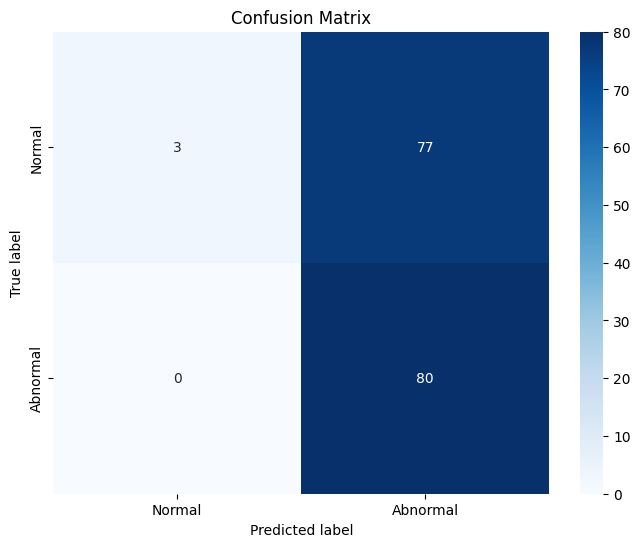

In [20]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
model = Fastflow(
    backbone="wide_resnet50_2", 
    flow_steps=8,
    pre_trained=True
)

In [32]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [33]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [34]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


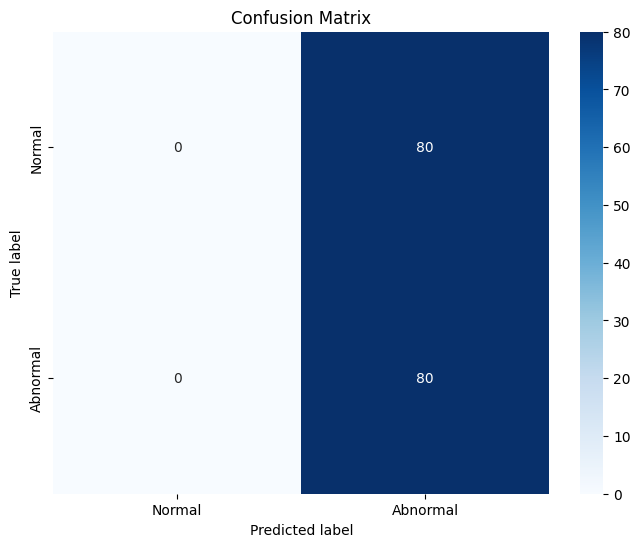

In [36]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
50 Epochs
model = Fastflow(
    backbone="wide_resnet50_2", 
    flow_steps=8,
    pre_trained=True
)

In [41]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [42]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [43]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.58125
Precision: 0.54421768707483
Recall: 1.0
F1 Score: 0.7048458149779736


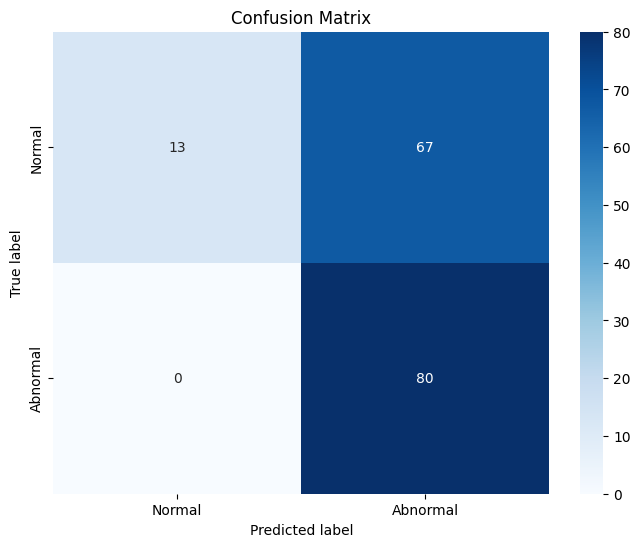

In [45]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
50 Epochs
model = Fastflow(
    backbone="deit_base_distilled_patch16_384", 
    flow_steps=8,
    pre_trained=True
)

In [61]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [62]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [63]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.66875
Precision: 0.6015037593984962
Recall: 1.0
F1 Score: 0.7511737089201878


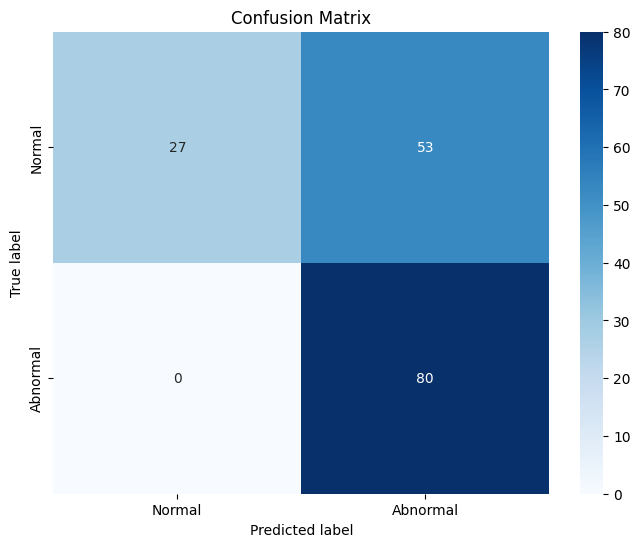

In [65]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
50 Epochs
model = Fastflow(
    backbone="cait_m48_448", 
    flow_steps=8,
    pre_trained=True
)

In [12]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [13]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [14]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.60625
Precision: 0.5594405594405595
Recall: 1.0
F1 Score: 0.7174887892376681


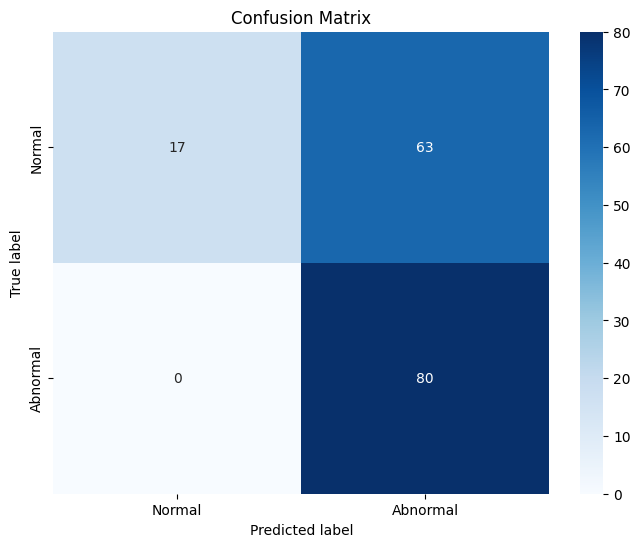

In [16]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
100 Epochs
model = Fastflow(
    backbone="deit_base_distilled_patch16_384", 
    flow_steps=8,
    pre_trained=True
)

In [ ]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)